# Imports and Inputs

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta, timezone

from dune_client.client import DuneClient
from config import key

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/tmp/ipykernel_1657/3756105138.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Links to dune queries to refresh before importing:

[Capital Pool in ETH](https://dune.com/queries/3773645/6345766?display_currency_e15077=ETH)

[RAMM Volumes](https://dune.com/queries/3219988/5394288)

[Full List Of Covers V2](https://dune.com/queries/2303588/3773262)

In [2]:
# import jsons of capital pool, ramm volume and covers from dune api 
dune = DuneClient(key)
cap_pool_result = dune.get_latest_result_dataframe(3773645)
ramm_volume_result = dune.get_latest_result_dataframe(3219988)
covers_list_result = dune.get_latest_result_dataframe(2303588)

# Investment Newsletter Data

Kiln Rewards - [AB Safe Enzyme App](https://app.safe.global/apps/open?safe=eth:0x51ad1265C8702c9e96Ea61Fe4088C2e22eD4418e&appUrl=https%3A%2F%2Fapp.enzyme.finance)

In [3]:
# manually input the valuation date as a string in the format 'dd-mm-yyyy'
valn_date_str = '31-05-2024'

# manually input idle Enzyme Portion
Enzyme_idle_portion = 6585
# manually input kiln rewards
kiln_first_round = 181.45
# create datetime object of 2023/08/30 when the Kiln validators were activated 
# kiln_deposit_date = datetime(year=2023, month=8, day=30, tzinfo=timezone.utc)
kiln_deposit_date = datetime(year=2023, month=8, day=30)

# create datetime objects of 2024/04/24 and 2024/04/26 when the Kiln rewards were first claimed.
    # Note that the values for 2024/04/25 will be inaccurate
# kiln_claim_start_date = datetime(year=2024, month=4, day=24, tzinfo=timezone.utc)
# kiln_claim_end_date = datetime(year=2024, month=4, day=26, tzinfo=timezone.utc)
kiln_claim_start_date = datetime(year=2024, month=4, day=24)
kiln_claim_end_date = datetime(year=2024, month=4, day=26)
kiln_current = 25.6677

kiln_total_rewards = kiln_first_round + kiln_current

# manually input Dai Cover Re Monthly Withdrawals
dai_cover_re_withdrawals = 4_090_353

# average days in month
avg_days_in_month = 30.436875

In [4]:
# create valuation datetime
# valn_date = datetime.strptime(valn_date_str, '%d-%m-%Y').replace(tzinfo=timezone.utc)
valn_date = datetime.strptime(valn_date_str, '%d-%m-%Y')
# create valuation datetimes for 30 days and 365 days ago
# eom_before_valn_date = datetime(year=valn_date.year, month=valn_date.month, day=1, tzinfo=timezone.utc) - timedelta(days=1)
eom_before_valn_date = datetime(year=valn_date.year, month=valn_date.month, day=1) - timedelta(days=1)

In [5]:
# coingecko ETH API for ETH-USD at valuation date
url = 'https://api.coingecko.com/api/v3/coins/ethereum/history'
eth_price_params_valn = {'date': valn_date_str}
eth_usd_valn = requests.get(url, params=eth_price_params_valn).json()['market_data']['current_price']['usd']

## Processing Capital Pool Table

In [6]:
cap_pool_result

,block_date,avg_eth_usd_price,capital_pool_display_curr,eth_display_curr,dai_display_curr,nxmty_display_curr,steth_display_curr,reth_display_curr,usdc_display_curr,cover_re_usdc_display_curr,aave_collateral_weth_display_curr,aave_debt_usdc_display_curr
0,2024-06-05 00:00:00,3807.328214,86527.189361,13586.212220,284.077959,13352.573252,33635.336859,14805.023368,1.261150,3152.832113,9344.842419,-1634.969978
1,2024-06-04 00:00:00,3783.802986,86587.428199,13638.788715,285.723466,13352.573252,33635.336859,14801.545881,1.269054,3172.589941,9344.623468,-1645.022435
2,2024-06-03 00:00:00,3797.520972,86717.730981,13781.838179,284.647327,13352.626304,33632.408790,14798.647198,1.264216,3160.496063,9344.161264,-1638.358360
3,2024-06-02 00:00:00,3796.210590,86855.915744,13936.995943,284.549237,13352.679363,33629.401072,14783.283219,1.265424,3163.515565,9343.754168,-1639.528246
4,2024-06-01 00:00:00,3792.737535,86949.033139,14045.622754,276.496621,13352.732415,33626.500917,14777.128209,1.266689,3166.679271,9343.379157,-1640.772893
...,...,...,...,...,...,...,...,...,...,...,...,...
1836,2019-05-27 00:00:00,268.692708,23.625751,23.625751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
1837,2019-05-26 00:00:00,252.561806,23.629793,23.629793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
1838,2019-05-25 00:00:00,251.959896,22.633834,22.633834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
1839,2019-05-24 00:00:00,249.477361,21.537876,21.537876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000


In [7]:
# process capital pool table

df_cap_raw = cap_pool_result

# drop moving average columns
df_cap = df_cap_raw.drop(columns=['capital_pool_display_curr'])
# rename columns
df_cap.rename(columns={'eth_display_curr': 'ETH',
                       'dai_display_curr': 'DAI',
                       'reth_display_curr': 'rETH',
                       'steth_display_curr': 'stETH',
                       'nxmty_display_curr': 'Enzyme',
                       'usdc_display_curr': 'USDC',
                       'cover_re_usdc_display_curr': 'Cover Re',
                       'aave_collateral_weth_display_curr': 'aEthWETH',
                       'aave_debt_usdc_display_curr': 'variableDebtEthUSDC',
                       'avg_eth_usd_price': 'rate_ETH_USD',
                       'block_date': 'day'
                  }, inplace=True)


# change day to a datetime
df_cap['day'] = pd.to_datetime(df_cap['day'])

# Adjust Enzyme for unclaimed Kiln returns
    # work out days since kiln deposit from the latest day and work out the rewards per day
days_first_kiln_rewards = (kiln_claim_start_date - kiln_deposit_date)/timedelta(days=1)
daily_first_kiln_rewards = kiln_first_round/days_first_kiln_rewards

days_current_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_claim_end_date)/timedelta(days=1)
daily_current_kiln_rewards = kiln_current/days_current_kiln_rewards

days_total_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_total_kiln_rewards = kiln_total_rewards / days_total_kiln_rewards

    # create a column for kiln rewards based on the daily values since validators went live
df_cap['kiln_rewards'] = 0
df_cap.loc[df_cap['day'] <= kiln_claim_start_date, 'kiln_rewards'] = daily_first_kiln_rewards * ((df_cap['day'] - kiln_deposit_date) / timedelta(days=1))
df_cap.loc[df_cap['day'] >= kiln_claim_end_date, 'kiln_rewards'] = daily_current_kiln_rewards * ((df_cap['day'] - kiln_claim_end_date) / timedelta(days=1))
df_cap.loc[df_cap['kiln_rewards'] < 0, 'kiln_rewards'] = 0

    # Add Kiln rewards to Enzyme column and then drop the Kiln rewards column
df_cap['Enzyme'] = df_cap['Enzyme'] + df_cap['kiln_rewards']
df_cap.drop(columns=['kiln_rewards'], inplace=True)

# add all the columns except day and the exchange rate together to get numeric total
df_cap['sum'] = df_cap.drop(columns=['day', 'rate_ETH_USD']).sum(axis=1)

# work out net aave position
df_cap['Aave (net)'] = df_cap['aEthWETH'] + df_cap['variableDebtEthUSDC']

/tmp/ipykernel_1657/2737571135.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  181.45         180.68760504   179.92521008 ... -1187.81134454
 -1188.5737395  -1189.33613445]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cap.loc[df_cap['day'] <= kiln_claim_start_date, 'kiln_rewards'] = daily_first_kiln_rewards * ((df_cap['day'] - kiln_deposit_date) / timedelta(days=1))


In [8]:
df_cap.loc[df_cap['day'] == eom_before_valn_date]

,day,rate_ETH_USD,ETH,DAI,Enzyme,stETH,rETH,USDC,Cover Re,aEthWETH,variableDebtEthUSDC,sum,Aave (net)
36,2024-04-30,3069.918299,26291.552966,1643.925374,13356.997194,33535.865479,14766.45998,558.291909,0.0,0.0,-0.0,90153.092902,0.0


In [9]:
df_cap.loc[df_cap['day'] == valn_date]

,day,rate_ETH_USD,ETH,DAI,Enzyme,stETH,rETH,USDC,Cover Re,aEthWETH,variableDebtEthUSDC,sum,Aave (net)
5,2024-05-31,3768.0025,14114.203758,272.782221,13375.244704,33623.618159,14795.68645,1.274981,3187.407884,9343.003483,-1651.115935,87062.105703,7691.887548


In [10]:
df_cap.loc[(df_cap['day'] <= valn_date) & (df_cap['day'] >= eom_before_valn_date)]

,day,rate_ETH_USD,ETH,DAI,Enzyme,stETH,rETH,USDC,Cover Re,aEthWETH,variableDebtEthUSDC,sum,Aave (net)
5,2024-05-31,3768.002500,14114.203758,272.782221,13375.244704,33623.618159,14795.686450,1.274981,3187.407884,9343.003483,-1651.115935,87062.105703,7691.887548
6,2024-05-30,3764.666424,14179.539108,272.996356,13374.656072,33620.602905,14795.279748,1.276138,3190.300731,9342.627698,-1652.111208,87125.167548,7690.516490
7,2024-05-29,3807.424618,14273.446195,269.923308,13374.067454,33617.623023,14798.960869,1.262029,3155.028058,9342.257346,-1633.380843,87199.187439,7708.876503
8,2024-05-28,3858.581632,14380.646585,266.490411,13373.478814,33614.722311,14796.413023,1.245253,3113.089229,9341.914320,-1611.143786,87276.856160,7730.770535
9,2024-05-27,3908.719097,14456.226492,262.913702,13372.890182,33611.757101,14791.820382,1.228849,3072.079773,9341.557796,-1589.538164,87320.936112,7752.019631
10,2024-05-26,3805.207292,14582.934974,265.408984,13372.301543,33608.901536,14788.725058,1.262200,3155.455361,9341.207628,-1632.286277,87483.911008,7708.921351
11,2024-05-25,3746.725069,14676.272069,266.027525,13371.712926,33606.178677,14789.143027,1.282098,3205.199448,9340.843772,-1657.620753,87599.038787,7683.223019
12,2024-05-24,3731.738299,14738.056715,267.098249,13371.124287,33603.397467,14791.515844,1.287388,3218.425871,9340.476737,-1664.060905,87667.321654,7676.415832
13,2024-05-23,3796.578924,14846.316953,262.554762,13370.535656,33599.496783,14782.611821,1.265181,3162.909784,9340.152590,-1634.893145,87730.950386,7705.259445
14,2024-05-22,3750.135868,24292.654194,1357.988506,13369.947024,33596.561158,14799.739213,456.817000,0.000000,0.000000,-0.000000,87873.707096,0.000000


## Pie Chart of Assets at Valuation Date

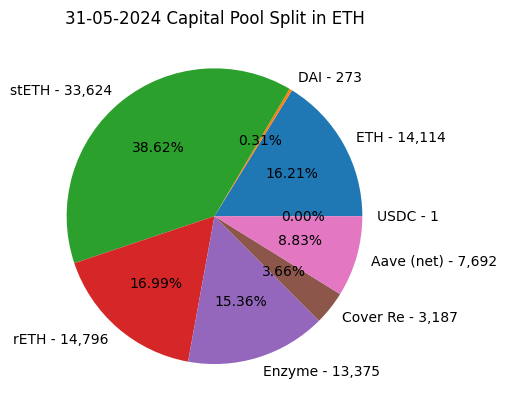

In [11]:
# pie chart of assets
asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme', 'Cover Re', 'Aave (net)', 'USDC']
valn_date_row = df_cap.loc[df_cap['day'] == valn_date][asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(asset_list):
    formatted_value = '{:,.0f}'.format(valn_date_row.values[0][n])
    labels.append(f'{i} - {formatted_value}')

# create chart
plt.pie(valn_date_row.values[0], labels=labels, autopct='%1.2f%%')
plt.title(f'{valn_date_str} Capital Pool Split in ETH');

## Monthly Changes in Capital Pool

### RAMM Net Withdrawals

In [12]:
# RAMM Net Withdrawals
df_ramm = ramm_volume_result

# change timestamp to datetime format and normalise all dates to midnight
df_ramm['ts'] = pd.to_datetime(df_ramm['ts']).dt.floor('D')

# group by date, take the latest value and re-sort into descending order
df_ramm = df_ramm.groupby(by=df_ramm['ts'].dt.date, as_index=False).first().\
            sort_values(['ts'], ascending=False).reset_index(drop=True)

# determine net ramm flows 30 days before and on the valuation date by subtracting redemptions from mints
ramm_flows_monthly_opening = df_ramm.loc[df_ramm['ts'] == eom_before_valn_date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == eom_before_valn_date]['cummulative_eth_out'].values[0]
ramm_flows_monthly_closing = df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_out'].values[0]

# determine net flows from ramm in 30 days before valuation date 
ramm_flow_monthly_change = ramm_flows_monthly_closing - ramm_flows_monthly_opening
ramm_flow_monthly_change

-2860.5967324089215

### Cover Fees

In [13]:
df_covers = covers_list_result
net_of_commission_ratio = 0.85
eth_usd_closing = df_cap.loc[df_cap['day'] == valn_date]['rate_ETH_USD'].values[0]

# change timestamp to datetime format and normalise all dates to midnight
df_covers['cover_start_time'] = pd.to_datetime(df_covers['cover_start_time']).dt.floor('D').dt.tz_localize(None)

# filter for covers that were bought the month of the valn date
df_covers_30_days = df_covers[(df_covers['cover_start_time'] > eom_before_valn_date) & (df_covers['cover_start_time']<=valn_date)]

# filter for covers that were paid for in ETH
df_covers_30_days_eth = df_covers_30_days[df_covers_30_days['premium_asset'] == 'ETH']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_eth = df_covers_30_days_eth['premium_native'].sum() * net_of_commission_ratio
print(f'ETH Cover Fees = {monthly_cover_fees_eth}')

# filter for covers that were paid for in DAI
df_covers_30_days_dai = df_covers_30_days[df_covers_30_days['premium_asset'] == 'DAI']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_dai = df_covers_30_days_dai['premium_native'].sum() * net_of_commission_ratio
monthly_cover_fees_dai_in_eth = monthly_cover_fees_dai / eth_usd_closing
print(f'DAI Cover Fees = {monthly_cover_fees_dai_in_eth}')

monthly_cover_fees = monthly_cover_fees_eth + monthly_cover_fees_dai_in_eth
print(f'Total Cover Fees = {monthly_cover_fees}')

ETH Cover Fees = 22.706859595283788
DAI Cover Fees = 19.084634753500968
Total Cover Fees = 41.79149434878475


### FX Impacts

In [14]:
# exchange rate changes
eth_usd_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['rate_ETH_USD'].values[0]

# get net monthly change from opening DAI
dai_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['DAI'].values[0]

# dai_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['DAI'].values[0]
# dai_monthly_closing_less_fees = dai_monthly_closing - monthly_cover_fees_dai_in_eth

# # allow for withdrawals
# dai_withdrawals_eth = dai_cover_re_withdrawals / eth_usd_opening

# dai_change = dai_monthly_opening - dai_withdrawals_eth - dai_monthly_closing_less_fees
dai_fx_change = dai_monthly_opening * eth_usd_opening / eth_usd_closing - dai_monthly_opening

print(f'DAI FX Impact = {dai_fx_change}')

DAI FX Impact = -304.5641110352801


In [15]:
usdc_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['USDC'].values[0]

usdc_fx_change = usdc_monthly_opening * eth_usd_opening / eth_usd_closing - usdc_monthly_opening

print(f'USDC FX Impact = {usdc_fx_change}')

USDC FX Impact = -103.43272362974147


#### TEMPORARY For New Investment - FX Impacts Allowing for Cover Re investment

Next time treat Cover Re, Aave Debt, USDC and DAI as per above.

In [16]:
cover_re_date_str = '23-05-2024'
cover_re_date = datetime.strptime(cover_re_date_str, '%d-%m-%Y')
eth_usd_cover_re_date = df_cap.loc[df_cap['day'] == cover_re_date]['rate_ETH_USD'].values[0]

In [17]:
# USDC Split into before and after Cover Re
usdc_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['USDC'].values[0]
usdc_cover_re_opening = df_cap.loc[df_cap['day'] == cover_re_date]['USDC'].values[0]
# Before Cover Re
usdc_fx_change_pre_cover_re = usdc_monthly_opening * eth_usd_opening / eth_usd_cover_re_date - usdc_monthly_opening
print(f'USDC FX Impact Pre Cover Re = {usdc_fx_change_pre_cover_re}')
# After Cover Re
usdc_fx_change_post_cover_re = usdc_cover_re_opening * eth_usd_cover_re_date / eth_usd_closing - usdc_cover_re_opening
print(f'USDC FX Impact Post Cover Re = {usdc_fx_change_post_cover_re}')

USDC FX Impact Pre Cover Re = -106.85639768398295
USDC FX Impact Post Cover Re = 0.009595099938464413


In [18]:
# DAI Split into before and after Cover Re
dai_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['DAI'].values[0]
dai_cover_re_opening = df_cap.loc[df_cap['day'] == cover_re_date]['DAI'].values[0]
# Before Cover Re
dai_fx_change_pre_cover_re = dai_monthly_opening * eth_usd_opening / eth_usd_cover_re_date - dai_monthly_opening
print(f'DAI FX Impact Pre Cover Re = {dai_fx_change_pre_cover_re}')
# After Cover Re
dai_fx_change_post_cover_re = dai_cover_re_opening * eth_usd_cover_re_date / eth_usd_closing - dai_cover_re_opening
print(f'DAI FX Impact Post Cover Re = {dai_fx_change_post_cover_re}')

DAI FX Impact Pre Cover Re = -314.64533299494997
DAI FX Impact Post Cover Re = 1.9912078346272892


In [19]:
# Cover Re FX impact
cover_re_opening = df_cap.loc[df_cap['day'] == cover_re_date]['Cover Re'].values[0]

# FX Impact
cover_re_fx_change = cover_re_opening * eth_usd_cover_re_date / eth_usd_closing - cover_re_opening
print(f'Cover Re FX Impact = {cover_re_fx_change}')

Cover Re FX Impact = 23.987417695385375


In [20]:
# debtUSDC FX impact
debtUSDC_opening = df_cap.loc[df_cap['day'] == cover_re_date]['variableDebtEthUSDC'].values[0]

# FX Impact
debtUSDC_fx_change = debtUSDC_opening * eth_usd_cover_re_date / eth_usd_closing - debtUSDC_opening
print(f'debtUSDC FX Impact = {debtUSDC_fx_change}')

debtUSDC FX Impact = -12.398983033101558


In [21]:
# Total FX Impacts
fx_change = dai_fx_change_pre_cover_re + dai_fx_change_post_cover_re + \
            usdc_fx_change_pre_cover_re + usdc_fx_change_post_cover_re + \
            cover_re_fx_change + debtUSDC_fx_change

print(f'Total FX Impact = {fx_change}')

Total FX Impact = -407.91249308208336


## Monthly Returns on Investments

In [22]:
# Full Monthly Returns

# ETH denominated monthly returns on individual investments

# stETH metrics in ETH
stETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['stETH'].values[0]
stETH_closing = df_cap.loc[df_cap['day'] == valn_date]['stETH'].values[0]
stETH_monthly_return = stETH_closing - stETH_monthly_opening
# stETH monthly percentage
stETH_monthly_percentage = stETH_monthly_return / stETH_monthly_opening
# stETH annualised return last month
stETH_monthly_APY = (1 + stETH_monthly_percentage) ** 12 - 1
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%')
print(f'stETH Monthly Return: {round(stETH_monthly_return, 3)}')

# rETH metrics in ETH
rETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['rETH'].values[0]
rETH_closing = df_cap.loc[df_cap['day'] == valn_date]['rETH'].values[0]
rETH_monthly_return = rETH_closing - rETH_monthly_opening
# rETH monthly percentage
rETH_monthly_percentage = rETH_monthly_return / rETH_monthly_opening
# rETH annualised return last month
rETH_monthly_APY = (1 + rETH_monthly_percentage) ** 12 - 1
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%')
print(f'rETH Monthly Return: {round(rETH_monthly_return, 3)}')

## Enzyme
Enzyme_fee = 0.0015
# Enzyme overall metrics in ETH
Enzyme_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['Enzyme'].values[0]
Enzyme_closing = df_cap.loc[df_cap['day'] == valn_date]['Enzyme'].values[0]
Enzyme_monthly_return = Enzyme_closing - Enzyme_monthly_opening
# Enzyme monthly percentage
Enzyme_monthly_percentage = Enzyme_monthly_return / Enzyme_monthly_opening
# Enzyme annualised return last month
Enzyme_monthly_APY = (1 + Enzyme_monthly_percentage) ** 12 - 1
Enzyme_monthly_APY_after_fees = Enzyme_monthly_APY - Enzyme_fee
    
# Kiln standalone metrics in ETH
Kiln_monthly_opening = Enzyme_monthly_opening - Enzyme_idle_portion
Kiln_closing = Enzyme_closing - Enzyme_idle_portion
Kiln_monthly_return = Kiln_closing - Kiln_monthly_opening
# Kiln monthly percentage
Kiln_monthly_percentage = Kiln_monthly_return / Kiln_monthly_opening
# Kiln annualised return last month
Kiln_monthly_APY = (1 + Kiln_monthly_percentage) ** 12 - 1
Kiln_monthly_APY_after_fees = Kiln_monthly_APY - Enzyme_fee

print(f'Enzyme Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%; Kiln Portion Monthly APY: {round(Kiln_monthly_APY_after_fees * 100, 3)}%')
print(f'Kiln Monthly Return: {round(Kiln_monthly_return, 3)}')

stETH Monthly APY: 3.186%
stETH Monthly Return: 87.753
rETH Monthly APY: 2.401%
rETH Monthly Return: 29.226
Enzyme Monthly APY: 1.502%; Kiln Portion Monthly APY: 3.132%
Kiln Monthly Return: 18.248


In [23]:
# Partial Returns

# aEthWETH metrics in ETH
aEthWETH_opening = df_cap.loc[df_cap['day'] == cover_re_date]['aEthWETH'].values[0]
aEthWETH_closing = df_cap.loc[df_cap['day'] == valn_date]['aEthWETH'].values[0]
aEthWETH_return = aEthWETH_closing - aEthWETH_opening

# days active
aEthWETH_active_days = (valn_date - cover_re_date) / timedelta(days=1)

# aEthWETH monthly percentage
aEthWETH_monthly_percentage = (1 + aEthWETH_return / aEthWETH_opening) ** (avg_days_in_month / aEthWETH_active_days) - 1
# aEthWETH annualised return last month
aEthWETH_APY = (1 + aEthWETH_monthly_percentage) ** 12 - 1
print(f'aEthWETH APY: {round(aEthWETH_APY * 100, 3)}%')
print(f'aEthWETH Return: {round(aEthWETH_return, 3)}')

# debtUSDC metrics in ETH
debtUSDC_opening = df_cap.loc[df_cap['day'] == cover_re_date]['variableDebtEthUSDC'].values[0]
debtUSDC_closing = df_cap.loc[df_cap['day'] == valn_date]['variableDebtEthUSDC'].values[0]
debtUSDC_return = debtUSDC_closing - (debtUSDC_opening + debtUSDC_fx_change)

# days active
debtUSDC_active_days = (valn_date - cover_re_date) / timedelta(days=1)

# debtUSDC monthly percentage
debtUSDC_monthly_percentage = (1 + debtUSDC_return / debtUSDC_opening) ** (avg_days_in_month / debtUSDC_active_days) - 1
# debtUSDC annualised return last month
debtUSDC_APY = (1 + debtUSDC_monthly_percentage) ** 12 - 1
print(f'debtUSDC APY: {round(debtUSDC_APY * 100, 3)}%')
print(f'debtUSDC Return: {round(debtUSDC_return, 3)}')

# Aave Net
aave_net_return = aEthWETH_return + debtUSDC_return

# Aave net monthly percentage
aave_net_monthly_percentage = (1 + aave_net_return / aEthWETH_opening) ** (avg_days_in_month / aEthWETH_active_days) - 1
# Aave net annualised return last month
aave_net_APY = (1 + aave_net_monthly_percentage) ** 12 - 1
print(f'Aave Net APY: {round(aave_net_APY * 100, 3)}%')
print(f'Aave Net Return: {round(aave_net_return, 3)}')

aEthWETH APY: 1.403%
aEthWETH Return: 2.851
debtUSDC APY: 11.255%
debtUSDC Return: -3.824
Aave Net APY: -0.474%
Aave Net Return: -0.973


/tmp/ipykernel_1657/2706178178.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(['{:,.1%}'.format(x) for x in tick_vals])


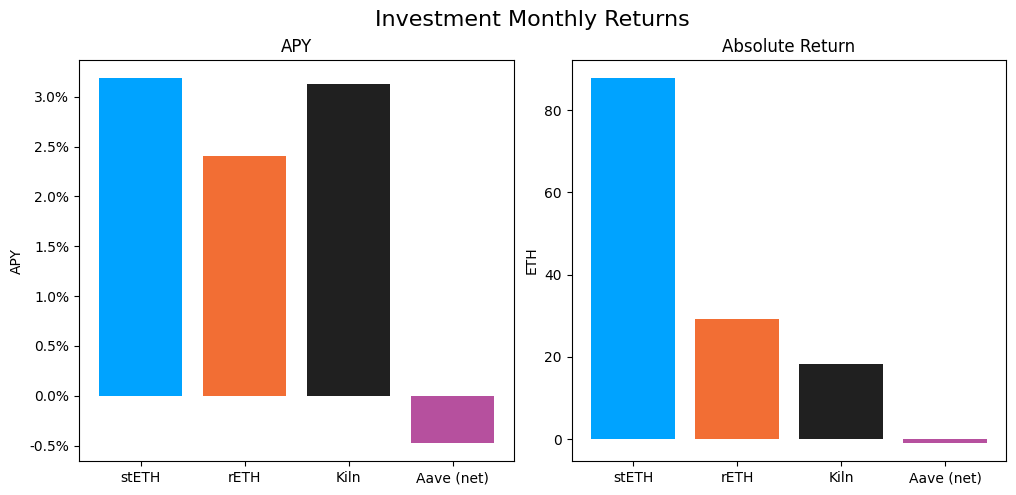

In [24]:
# MONTHLY RETURN GRAPHS FOR INDIVIDUAL INVESTMENTS

labels = ['stETH', 'rETH', 'Kiln', 'Aave (net)']
colors = ['#00a3ff', '#f26e34', '#202020', '#b6509e']

# Destructuring initialization
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle(f'Investment Monthly Returns', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Subplot
axs[0].bar(labels, [stETH_monthly_APY, rETH_monthly_APY, Kiln_monthly_APY_after_fees, aave_net_APY], color=colors)
axs[0].set_title('APY')
axs[0].set_ylabel('APY')
tick_vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.1%}'.format(x) for x in tick_vals])

# Subplot
axs[1].bar(labels, [stETH_monthly_return, rETH_monthly_return, Kiln_monthly_return*(1-0.0015), aave_net_return], color=colors);
axs[1].set_title('Absolute Return')
axs[1].set_ylabel('ETH')

plt.show();

In [25]:
# Total Monthly APY on the Capital Pool

# Total ETH earned
total_monthly_inv_earnings = round(stETH_monthly_return + rETH_monthly_return + Kiln_monthly_return + aave_net_return, 3)

# averaging the total ETH value of capital pool over the monthly period
total_cap_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['sum'].values[0]
total_cap_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['sum'].values[0]
avg_total_cap_pool = (total_cap_monthly_closing + total_cap_monthly_opening) / 2

# monthly apy based on total earning
total_monthly_percentage = total_monthly_inv_earnings / avg_total_cap_pool
total_monthly_APY = ((1 + total_monthly_percentage) ** 12 - 1)

print(f'Total Monthly APY: {round(total_monthly_APY * 100, 3)}%')
print('Based on average Capital Pool amount over the monthly period')
print(f'Total ETH Earned: {total_monthly_inv_earnings}')

Total Monthly APY: 1.833%
Based on average Capital Pool amount over the monthly period
Total ETH Earned: 134.254


In [26]:
# Printout

print(f'stETH Monthly Return: {round(stETH_monthly_return, 3)}')
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%\n')
print(f'rETH Monthly Return: {round(rETH_monthly_return, 3)}')
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%\n')
print(f'Kiln Monthly Return: {round(Kiln_monthly_return, 3)}')
print(f'Enzyme Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%; Kiln Portion Monthly APY: {round(Kiln_monthly_APY_after_fees * 100, 3)}%\n')
print(f'aEthWETH Return: {round(aEthWETH_return, 3)}')
print(f'aEthWETH APY: {round(aEthWETH_APY * 100, 3)}%')
print(f'debtUSDC Return: {round(debtUSDC_return, 3)}')
print(f'debtUSDC APY: {round(debtUSDC_APY * 100, 3)}%')
print(f'Aave Net Return: {round(aave_net_return, 3)}')
print(f'Aave Net APY: {round(aave_net_APY * 100, 3)}%\n')
print(f'Total ETH Earned: {total_monthly_inv_earnings}')
print(f'Total Monthly APY: {round(total_monthly_APY * 100, 3)}%')
print('Based on average Capital Pool amount over the monthly period\n')

print ('All returns after fees')

stETH Monthly Return: 87.753
stETH Monthly APY: 3.186%

rETH Monthly Return: 29.226
rETH Monthly APY: 2.401%

Kiln Monthly Return: 18.248
Enzyme Monthly APY: 1.502%; Kiln Portion Monthly APY: 3.132%

aEthWETH Return: 2.851
aEthWETH APY: 1.403%
debtUSDC Return: -3.824
debtUSDC APY: 11.255%
Aave Net Return: -0.973
Aave Net APY: -0.474%

Total ETH Earned: 134.254
Total Monthly APY: 1.833%
Based on average Capital Pool amount over the monthly period

All returns after fees


## Monthly Changes in Capital Pool 

/tmp/ipykernel_1657/875067302.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  waterfall_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])
/tmp/ipykernel_1657/875067302.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/home/rei/.pyenv/versions/3.10.6/envs/investment_monitoring/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/rei/.pyenv/versions/3.10.6/envs/investment_monitoring/lib/python3.10/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element

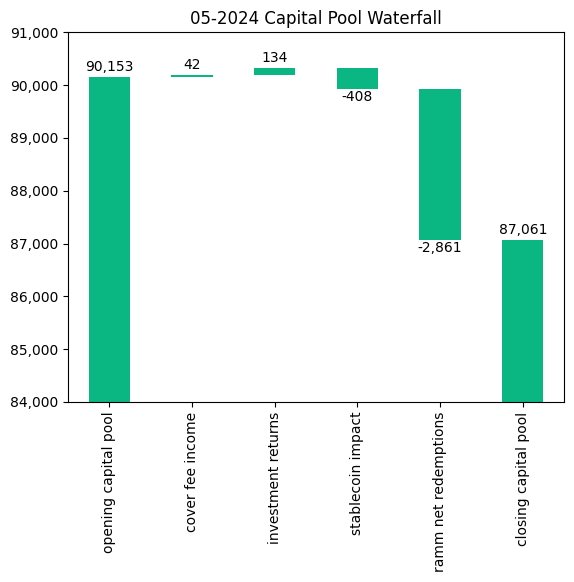

In [27]:
# waterfall chart for changes in the capital pool

# set limits on chart manually
bottom = 84_000
top = 91_000

# create dataframe with relevant categories
index = ['opening capital pool', 'cover fee income', 'investment returns', 'stablecoin impact', 'ramm net redemptions']
data = {'amount': [total_cap_monthly_opening, monthly_cover_fees, total_monthly_inv_earnings, fx_change, ramm_flow_monthly_change]}
df_waterfall = pd.DataFrame(data=data, index=index)

# create a shifted dataframe by one space and fill the empty space with zero
df_shift = df_waterfall.amount.cumsum().shift(1).fillna(0)

# add the 'closing' line to both dataframes
total = df_waterfall.sum().amount
df_waterfall.loc['closing capital pool'] = total
df_shift.loc['closing capital pool'] = 0

# define the Nexus Mutual green color
color = '#0AB682'

# create waterfall plot
waterfall_plot = df_waterfall.plot.bar(stacked=True, bottom=df_shift,
                                   legend=None, color=color, title=f'{valn_date_str[-7:]} Capital Pool Waterfall')
waterfall_plot.set_ylim(bottom=bottom, top=top)

# change format of tick values
tick_vals = waterfall_plot.get_yticks()
waterfall_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

# label loop for individual items
maximum = df_waterfall.max()
neg_offset = maximum / 400
pos_offset = maximum / 800

y_height = df_shift

loop = 0
for index, row in df_waterfall.iterrows():
    y = y_height[loop] + row['amount']
    # determine negative or positive offset
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    waterfall_plot.annotate("{:,.0f}".format(row['amount']), (loop, y), ha="center")
    loop+=1

In [28]:
# Total change in capital pool
capital_pool_change = df_waterfall.loc['closing capital pool'].values[0] - df_waterfall.loc['opening capital pool'].values[0]
print(f'Capital Pool Total Change - {round(capital_pool_change, 2)}')
print(f'Capital Pool Percentage Change - {round(100 * capital_pool_change / (df_waterfall.loc["opening capital pool"].values[0]), 2)}%')

Capital Pool Total Change - -3092.46
Capital Pool Percentage Change - -3.43%


# Divestment Plan

## Pie Chart of Assets Today

In [58]:
today_row = df_cap.iloc[0]
today_row['Kiln'] = today_row['Enzyme'] - Enzyme_idle_portion
today_row['Enzyme Idle'] = Enzyme_idle_portion
today_row.rename({'Cover Re': 'Cover Re Investment', 'aEthWETH':'Cover Re Loan Collateral', 'variableDebtEthUSDC': 'Cover Re Loan Outstanding'}, inplace=True)
today_row

/tmp/ipykernel_1657/1517165823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today_row['Kiln'] = today_row['Enzyme'] - Enzyme_idle_portion
/tmp/ipykernel_1657/1517165823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today_row['Kiln'] = today_row['Enzyme'] - Enzyme_idle_portion
/tmp/ipykernel_1657/1517165823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today_row['Enzyme Idle'] = Enzyme_idle_portion
/tmp/ipykernel_1657

day                          2024-06-05 00:00:00
rate_ETH_USD                         3807.328214
ETH                                  13586.21222
DAI                                   284.077959
Enzyme                              13378.240952
stETH                               33635.336859
rETH                                14805.023368
USDC                                     1.26115
Cover Re Investment                  3152.832113
Cover Re Loan Collateral             9344.842419
Cover Re Loan Outstanding           -1634.969978
sum                                 86552.857061
Aave (net)                           7709.872441
Kiln                                 6793.240952
Enzyme Idle                                 6585
Name: 0, dtype: object

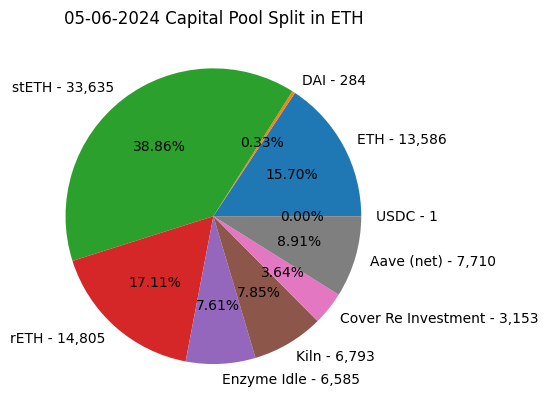

In [60]:
pie_asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme Idle', 'Kiln', 'Cover Re Investment', 'Aave (net)', 'USDC']
today_row_pie = today_row[pie_asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(pie_asset_list):
    formatted_value = '{:,.0f}'.format(today_row_pie.values[n])
    labels.append(f'{i} - {formatted_value}')

# create chart
# extract latest date in string format
today_date_str = df_cap.iloc[0]['day'].strftime('%d-%m-%Y')
# create chart
plt.pie(today_row_pie.values, labels=labels, autopct='%1.2f%%')
plt.title(f'{today_date_str} Capital Pool Split in ETH');

## Monthly Averages Since Start of 2024 

In [61]:
# get today's day, month and year

day_today = datetime.now().day
month_today = datetime.now().month
year_today = datetime.now().year

# get eth price today
eth_usd_today = df_cap.iloc[0]['rate_ETH_USD']

# manually input average start date
averages_start_date_str = '01-08-2023'
# create average start datetime
averages_start_date = datetime.strptime(averages_start_date_str, '%d-%m-%Y')

In [62]:
# loop through months since the start date and obtain averages

date = averages_start_date
ramm_flows = []
net_eth_fees = []
claim_ratio = 0.7
stETH_returns = []
rETH_returns = []

while date < datetime(year_today, month_today, 1):
    next_month = datetime(year = date.year + int(date.month / 12), month = (date.month % 12) + 1, day=date.day)
    
    # RAMM FLOWS
    # determine net ramm flows in month in 2024
    if date.year >= 2024:
        ramm_flows_opening = df_ramm.loc[df_ramm['ts'] == date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == date]['cummulative_eth_out'].values[0]
        ramm_flows_closing = df_ramm.loc[df_ramm['ts'] == next_month]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == next_month]['cummulative_eth_out'].values[0]
        ramm_flows_change = ramm_flows_closing - ramm_flows_opening
        ramm_flows.append(ramm_flows_change)
    
    # COVERS
    # filter for covers that were bought in the relevant month
    df_cover_flows = df_covers[(df_covers['cover_start_time']>=date) & (df_covers['cover_start_time']<next_month)]

    # filter for covers that were paid for in ETH
    # (note covers paid in NXM don't generate assets and covers paid for in DAI/USDC will be used to pay off the Cover Re loan)
    df_cover_flows = df_cover_flows[df_cover_flows['premium_asset'] == 'ETH']

    # work out cover fees, allowing for 15% commission
    eth_cover_fees = df_cover_flows['premium_native'].sum() * 0.85
    # append to list, allowing for 70% claim ratio
    net_eth_monthly_fees = eth_cover_fees * (1 - claim_ratio)
    net_eth_fees.append(net_eth_monthly_fees)
    
    # INVESTMENT INCOME
    # stETH
    stETH_opening = df_cap.loc[df_cap['day'] == date]['stETH'].values[0]
    stETH_closing = df_cap.loc[df_cap['day'] == next_month]['stETH'].values[0]
    stETH_returns.append(stETH_closing - stETH_opening)
    # rETH
    rETH_opening = df_cap.loc[df_cap['day'] == date]['rETH'].values[0]
    rETH_closing = df_cap.loc[df_cap['day'] == next_month]['rETH'].values[0]
    rETH_returns.append(rETH_closing - rETH_opening) 
    
    # move date along
    date = next_month

# Average Kiln rewards in month
days_total_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_total_kiln_rewards = kiln_total_rewards / days_total_kiln_rewards
avg_monthly_kiln_returns = daily_total_kiln_rewards * avg_days_in_month

# Average RAMM flows
avg_monthly_ramm_flows = sum(ramm_flows)/len(ramm_flows)

# Average ETH Cover Fees
avg_monthly_net_eth_fees = sum(net_eth_fees)/len(net_eth_fees)

# Average stETH returns
avg_monthly_stETH_returns = sum(stETH_returns)/len(stETH_returns)

# Average rETH returns
avg_monthly_rETH_returns = sum(rETH_returns)/len(rETH_returns)

print(f'Average monthly stETH returns = {avg_monthly_stETH_returns}')
print(f'Average monthly rETH returns = {avg_monthly_rETH_returns}')
print(f'Average monthly kiln returns = {avg_monthly_kiln_returns}')
print(f'Average monthly net ETH cover fees = {avg_monthly_net_eth_fees}')
print(f'Average monthly RAMM flows = {avg_monthly_ramm_flows}')

Average monthly stETH returns = 98.15506824058939
Average monthly rETH returns = 36.492883790833915
Average monthly kiln returns = 22.514341232812498
Average monthly net ETH cover fees = 3.314128423428238
Average monthly RAMM flows = -2975.093028385013


## Asset Projection

In [63]:
today_row

day                          2024-06-05 00:00:00
rate_ETH_USD                         3807.328214
ETH                                  13586.21222
DAI                                   284.077959
Enzyme                              13378.240952
stETH                               33635.336859
rETH                                14805.023368
USDC                                     1.26115
Cover Re Investment                  3152.832113
Cover Re Loan Collateral             9344.842419
Cover Re Loan Outstanding           -1634.969978
sum                                 86552.857061
Aave (net)                           7709.872441
Kiln                                 6793.240952
Enzyme Idle                                 6585
Name: 0, dtype: object

In [65]:
proj_asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme Idle', 'Kiln', 'Cover Re Investment', 'Cover Re Loan Collateral',
                   'Cover Re Loan Outstanding', 'USDC']
today_row_proj = today_row[proj_asset_list]

asset_df = pd.DataFrame(today_row_proj).T

projection_months = 12
aave_eth_supply_apy = 0.0154
aave_usdc_borrow_apy = 0.0871
cover_re_apy = 0.2

for i in range(projection_months):
    
    next_row = {}
    next_row['ETH'] = asset_df['ETH'].values[-1] + avg_monthly_ramm_flows + avg_monthly_net_eth_fees
    next_row['DAI'] = asset_df['DAI'].values[-1]
    next_row['USDC'] = asset_df['USDC'].values[-1]
    next_row['stETH'] = asset_df['stETH'].values[-1] + avg_monthly_stETH_returns
    next_row['rETH'] = asset_df['rETH'].values[-1] + avg_monthly_rETH_returns
    next_row['Kiln'] = asset_df['Kiln'].values[-1] + avg_monthly_kiln_returns
    next_row['Enzyme Idle'] = asset_df['Enzyme Idle'].values[-1]
    next_row['Cover Re Investment'] = asset_df['Cover Re Investment'].values[-1] * ((1 + cover_re_apy)**(1/12))
    next_row['Cover Re Loan Collateral'] = asset_df['Cover Re Loan Collateral'].values[-1] * ((1 + aave_eth_supply_apy)**(1/12))
    next_row['Cover Re Loan Outstanding'] = asset_df['Cover Re Loan Outstanding'].values[-1] * ((1 + aave_usdc_borrow_apy)**(1/12))
    
    asset_df.loc[len(asset_df)] = next_row

asset_df

,ETH,DAI,stETH,rETH,Enzyme Idle,Kiln,Cover Re Investment,Cover Re Loan Collateral,Cover Re Loan Outstanding,USDC
0,13586.21222,284.077959,33635.336859,14805.023368,6585,6793.240952,3152.832113,9344.842419,-1634.969978,1.26115
1,10614.43332,284.077959,33733.491927,14841.516252,6585,6815.755293,3201.100303,9356.751143,-1646.388183,1.26115
2,7642.65442,284.077959,33831.646995,14878.009136,6585,6838.269635,3250.107453,9368.675043,-1657.88613,1.26115
3,4670.87552,284.077959,33929.802063,14914.502019,6585,6860.783976,3299.864878,9380.614138,-1669.464376,1.26115
4,1699.09662,284.077959,34027.957132,14950.994903,6585,6883.298317,3350.384062,9392.568449,-1681.123481,1.26115
5,-1272.68228,284.077959,34126.1122,14987.487787,6585,6905.812658,3401.676668,9404.537993,-1692.86401,1.26115
6,-4244.46118,284.077959,34224.267268,15023.980671,6585,6928.327,3453.754536,9416.522791,-1704.686533,1.26115
7,-7216.24008,284.077959,34322.422336,15060.473555,6585,6950.841341,3506.629689,9428.522861,-1716.59162,1.26115
8,-10188.01898,284.077959,34420.577404,15096.966438,6585,6973.355682,3560.314333,9440.538225,-1728.57985,1.26115
9,-13159.79788,284.077959,34518.732473,15133.459322,6585,6995.870023,3614.82086,9452.5689,-1740.651802,1.26115


In [66]:
asset_df_6_mo = asset_df[:6].astype(float)
asset_df_6_mo_pos = asset_df_6_mo.drop(columns=['Cover Re Loan Outstanding'])

/tmp/ipykernel_1657/1641516350.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  projection_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);


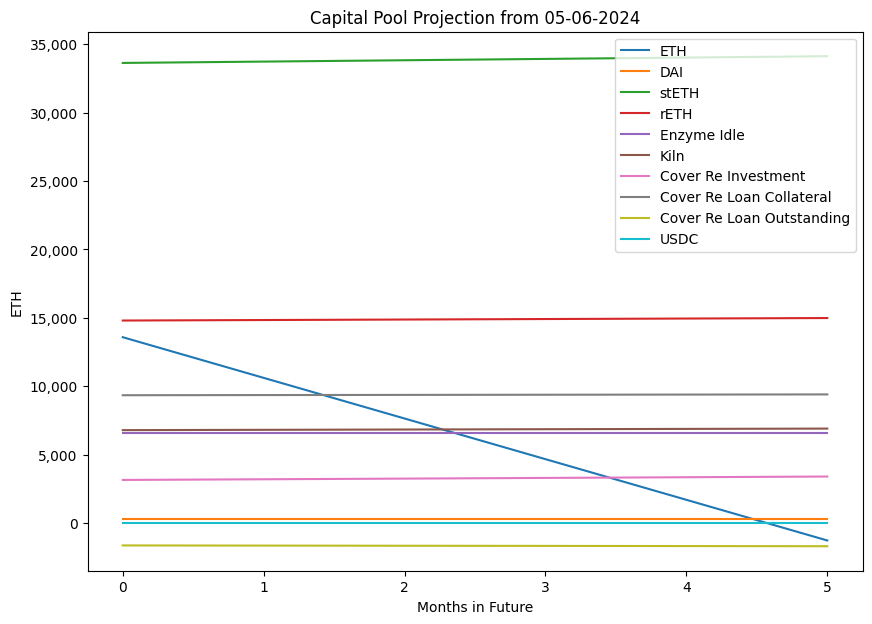

In [67]:
projection_plot = asset_df_6_mo.plot(title=f'Capital Pool Projection from {today_date_str}',
                                    figsize=(10, 7), legend=True, ylabel='ETH', xlabel='Months in Future')

tick_vals = projection_plot.get_yticks()
projection_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);

/tmp/ipykernel_1657/1806150064.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  projection_bar_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);


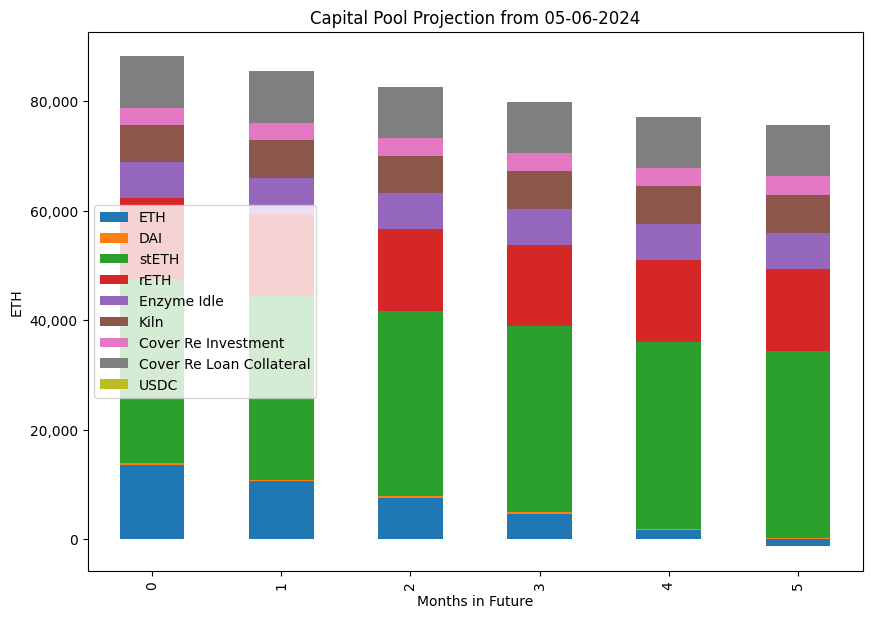

In [68]:
projection_bar_plot = asset_df_6_mo_pos.plot(kind='bar', stacked=True, title=f'Capital Pool Projection from {today_date_str}',
                                    figsize=(10, 7), legend=True, ylabel='ETH', xlabel='Months in Future')

tick_vals = projection_bar_plot.get_yticks()
projection_bar_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);

In [69]:
df_sum = asset_df_6_mo_pos.sum(axis=1)
df_rel = asset_df_6_mo_pos.div(df_sum, 0)*100
df_rel

,ETH,DAI,stETH,rETH,Enzyme Idle,Kiln,Cover Re Investment,Cover Re Loan Collateral,USDC
0,15.405995,0.322128,38.140567,16.788058,7.467017,7.703150,3.575133,10.596522,0.001430
1,12.424222,0.332514,39.485139,17.372033,7.707759,7.977859,3.746896,10.952101,0.001476
2,9.243689,0.343589,40.918927,17.994754,7.964470,8.270796,3.930962,11.331288,0.001525
3,5.843943,0.355423,42.451105,18.660206,8.238790,8.583836,4.128610,11.736509,0.001578
4,2.201626,0.368098,44.092150,19.372938,8.532596,8.919120,4.341302,12.170538,0.001634
5,-1.710059,0.381706,45.854080,20.138170,8.848037,9.279102,4.570716,12.636553,0.001695


In [70]:
for n in df_rel: 
    for i, (cs, ab, pc) in enumerate(zip(asset_df_6_mo_pos.cumsum(1)[n],  
                                         asset_df_6_mo_pos[n], df_rel[n])): 
        print(cs - ab / 2, i, str(np.round(pc, 1)) + '%')

6793.106109768929 0 15.4%
5307.216659788136 1 12.4%
3821.3272098073435 2 9.2%
2335.437759826551 3 5.8%
849.5483098457586 4 2.2%
-636.3411401350338 5 -1.7%
13728.251198854836 0 0.3%
10756.47229889325 1 0.3%
7784.693398931663 2 0.3%
4812.914498970078 3 0.4%
1841.135599008494 4 0.4%
-1130.6433009530908 5 0.4%
30687.958607440676 0 38.1%
27765.25724159939 1 39.5%
24842.555875758095 2 40.9%
21919.8545099168 3 42.5%
18997.153144075513 4 44.1%
16074.45177823422 5 45.9%
54908.138720722425 0 16.8%
52052.76133089686 1 17.4%
49197.38394107127 2 18.0%
46342.006551245686 3 18.7%
43486.6291614201 4 19.4%
40631.25177159453 5 20.1%
65603.15040473532 0 7.5%
62766.01945680517 1 7.7%
59928.88850887499 2 8.0%
57091.757560944825 3 8.2%
54254.62661301466 4 8.5%
51417.4956650845 5 8.8%
72292.27088078838 0 7.7%
69466.39710347464 1 8.0%
66640.52332616087 2 8.3%
63814.649548847105 3 8.6%
60988.77577153334 4 8.9%
58162.901994219596 5 9.3%
77265.30741313289 0 3.6%
74474.82490154465 1 3.7%
71684.71187017349 2 3.9%


/tmp/ipykernel_1657/4137318079.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  projection_bar_perc_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])


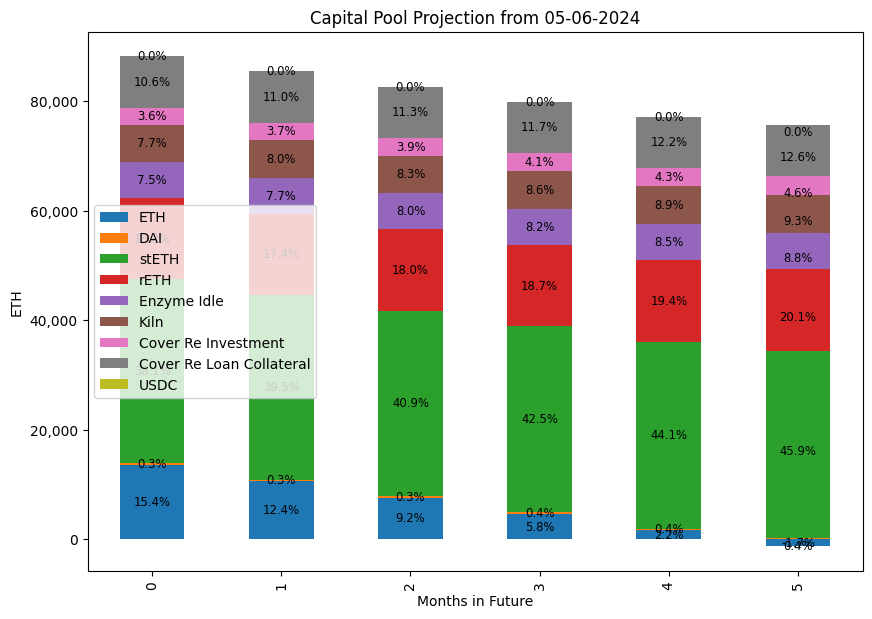

In [71]:
projection_bar_perc_plot = asset_df_6_mo_pos.plot(kind='bar', stacked=True, title=f'Capital Pool Projection from {today_date_str}',
                                    figsize=(10, 7), legend=True, ylabel='ETH', xlabel='Months in Future')

tick_vals = projection_bar_perc_plot.get_yticks()
projection_bar_perc_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

for n in df_rel: 
     for i, (cs, ab, pc) in enumerate(zip(asset_df_6_mo_pos.cumsum(1)[n],  
                                         asset_df_6_mo_pos[n], df_rel[n])): 
         projection_bar_perc_plot.text(y= cs - ab / 2, x=i, s=str(np.round(pc, 1)) + '%',
                             va = 'center', ha = 'center', size = 'small')